In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
Data=pd.read_excel("https://data.hossam.kr/G02/iris.xlsx")

## 데이터를 전반적으로 살펴보기

In [3]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
Data["Species"].value_counts()

Species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [5]:
target='Species'
feature=Data.columns.difference([target])

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["font.family"]='BM YEONSUNG'

### 간단한 시각화

<Figure size 640x480 with 0 Axes>

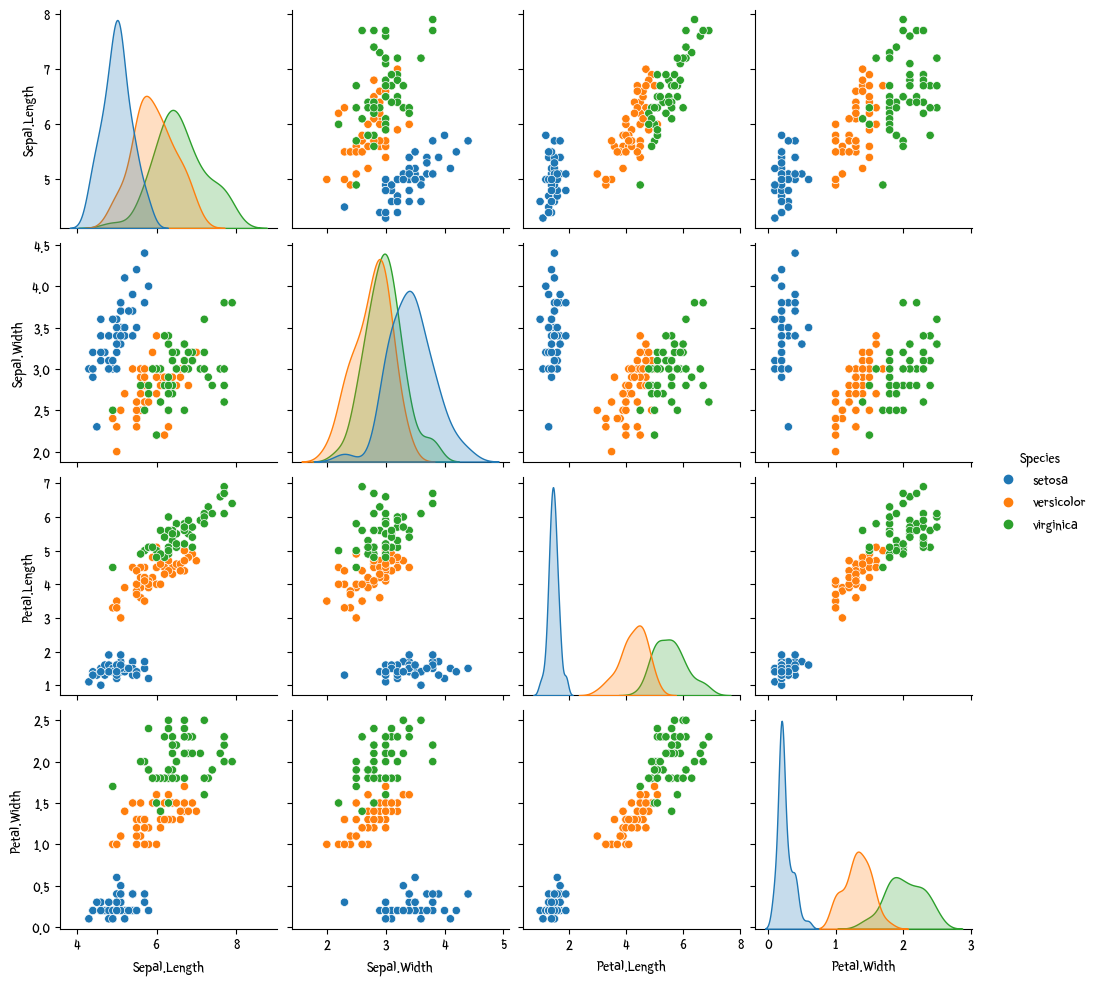

In [8]:
plt.figure()
sb.pairplot(Data,hue="Species")

In [8]:
Data[feature].corr(method='pearson')

,Petal.Length,Petal.Width,Sepal.Length,Sepal.Width
Petal.Length,1.000000,0.962865,0.871754,-0.428440
Petal.Width,0.962865,1.000000,0.817941,-0.366126
Sepal.Length,0.871754,0.817941,1.000000,-0.117570
Sepal.Width,-0.428440,-0.366126,-0.117570,1.000000


* 선형성 발견
> PCA 혹은 feature selection 을 고려하자

<Axes: >

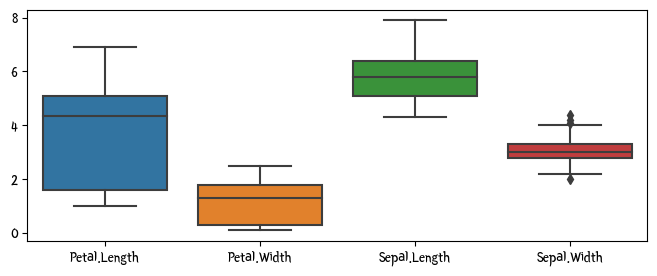

In [9]:
plt.figure(figsize=(8,3))
sb.boxplot(Data[feature])

<Axes: xlabel='Sepal.Length', ylabel='Sepal.Width'>

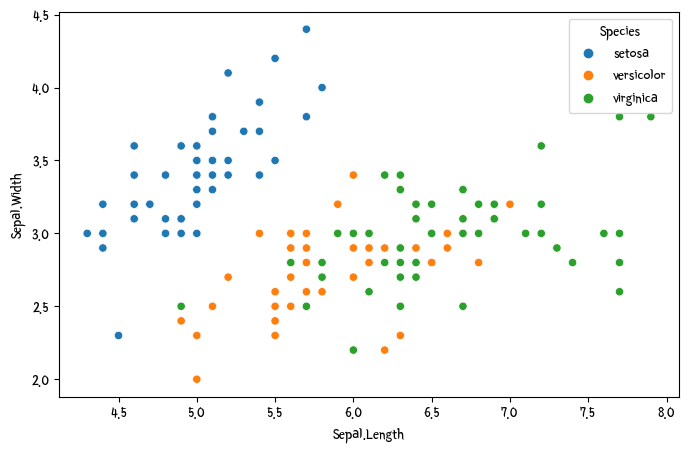

In [10]:
plt.figure(figsize=(8,5))
sb.scatterplot(Data,x=Data.columns[0],y=Data.columns[1],hue=target)

### PCA

In [11]:
import scipy as sp
import numpy as np

In [12]:
corr_matirx=Data[feature].corr()
eigen_value,eigen_vector=sp.linalg.eig(corr_matirx)
eigen_value=eigen_value/sum(eigen_value)

In [13]:
eig_result=dict(zip([f"P{i}" for i in range(1,5)],eigen_vector))

결과

In [14]:
eig_result_val=pd.DataFrame(list(zip([f"P{i}" for i in range(1,5)],eigen_value))).rename({0:"주성분",1:'eigen_value'},axis=1)
eig_result_val.sort_values(by='eigen_value',ascending=False,inplace=True)
eig_result_val["eigen_value"]=eig_result_val["eigen_value"].apply(lambda x:np.round(x,2))
eig_result_val

,주성분,eigen_value
0,P1,0.73+0.00j
3,P4,0.23+0.00j
2,P3,0.04+0.00j
1,P2,0.01+0.00j


In [15]:
eig_result_val["cumsum"],temp=0,0
for i in eig_result_val.index:
    eig_result_val.loc[i,"cumsum"]=temp+eig_result_val.loc[i,"eigen_value"]
    temp=eig_result_val.loc[i,"cumsum"]

In [16]:
eig_result_val

,주성분,eigen_value,cumsum
0,P1,0.73+0.00j,0.73+0.00j
3,P4,0.23+0.00j,0.96+0.00j
2,P3,0.04+0.00j,1.00+0.00j
1,P2,0.01+0.00j,1.01+0.00j


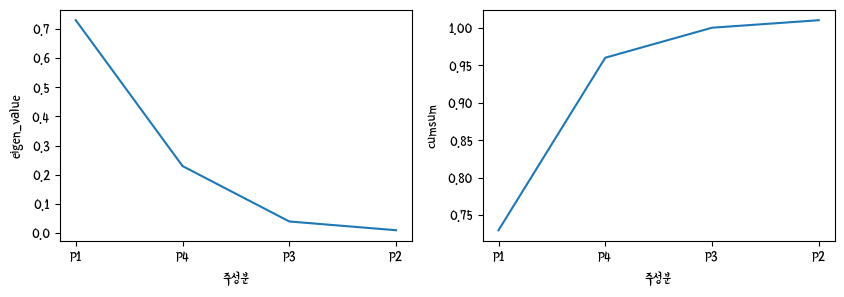

In [17]:
_,a=plt.subplots(1,2,figsize=(10,3))
sb.lineplot(y=eig_result_val["eigen_value"],x=eig_result_val["주성분"],ax=a[0])
sb.lineplot(y=eig_result_val["cumsum"],x=eig_result_val["주성분"],ax=a[1])
plt.show()
plt.close()

`P1`과 `P4`를 사용하면 차원축소로써 적절할 것이라 판단

In [18]:
pre_data=pd.DataFrame(dict(zip(["P1","P4"],[eig_result[x]@Data[feature].T for x in ["P1","P4"]])))
pre_data["Species"]=Data[target]

#### 시각화로 분포 다시 보기

<Axes: xlabel='P1', ylabel='P4'>

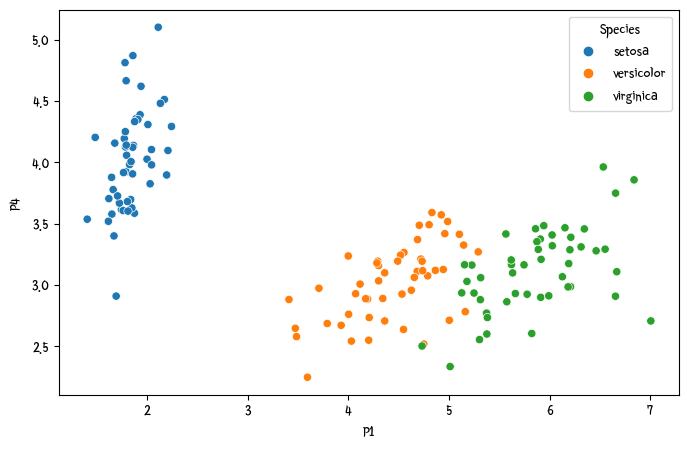

In [19]:
plt.figure(figsize=(8,5))
sb.scatterplot(data=pre_data,x="P1",y="P4",hue=target)

### 모델 만들기

In [20]:
import sklearn.model_selection as skmod
import sklearn.metrics as skmet
import sklearn.neighbors as sknei
import numpy as np
np.random.seed(101)

In [21]:
train,test=skmod.train_test_split(pre_data,train_size=0.7,stratify=pre_data[target],random_state=101)

In [22]:
# 초기 n값 설정
len(train)**(1/2)

10.246950765959598

In [23]:
# 유클리디안 모델('mincowski',p=2)
knn=sknei.KNeighborsClassifier(n_neighbors=11)
knn.fit(X=train[["P1","P4"]],y=train[target])

KNeighborsClassifier(n_neighbors=11)

학습결과

In [24]:
knn.score(X=train[["P1","P4"]],y=train[target])

0.9714285714285714

In [25]:
knn.score(X=test[["P1","P4"]],y=test[target])

0.9555555555555556

결과 저장

In [26]:
test["pred"]=knn.predict(test[["P1","P4"]])

과적합도 일어나지 않고 정확도가 `95%` 로 만족스러움.            
추가적인 모델성능향상을 위해선 CV를 통해 파라미터 최적화를 해야겠지만 생략 

 시각화로 결과확인

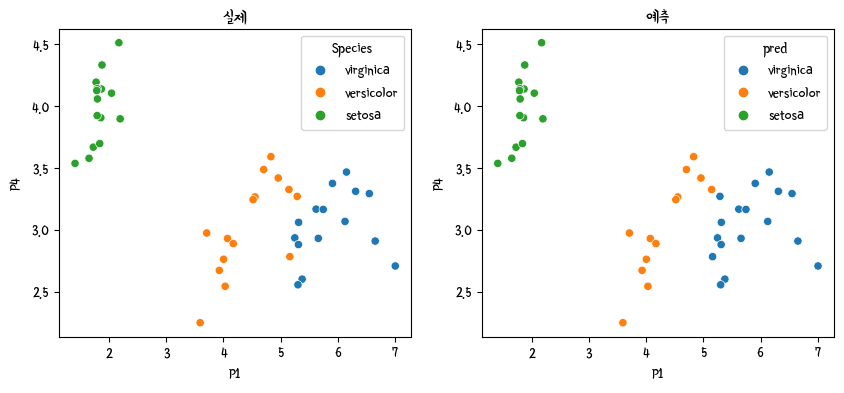

In [27]:
_,a=plt.subplots(1,2,figsize=(10,4))
sb.scatterplot(data=test,x="P1",y="P4",hue=target,ax=a[0])
sb.scatterplot(data=test,x="P1",y="P4",hue='pred',ax=a[1])
a[0].set_title("실제")
a[1].set_title("예측")
plt.show()
plt.close()

## 참고

> Softmax

In [28]:
import sklearn.linear_model as sklin

모델학습

In [29]:
softmax=sklin.LogisticRegression()
softmax.fit(X=train[["P1","P4"]],y=train[target])

LogisticRegression()

모델평가

In [30]:
softmax.score(X=train[["P1","P4"]],y=train[target])

0.9904761904761905

In [31]:
softmax.score(X=test[["P1","P4"]],y=test[target])

0.9555555555555556

과적합은 일어나지 않았고, 훈련면에선 KNN보다 더 높은 성능을 보임

In [32]:
import scipy as sp

In [33]:
softmax_result=pd.DataFrame(data=sp.special.softmax(softmax.decision_function(X=test[["P1","P4"]]),axis=1),columns=softmax.classes_)
softmax_result["predict"]=softmax.predict(test[["P1","P4"]])
softmax_result.set_index(test.index,inplace=True)
softmax_result[softmax.classes_]=softmax_result[softmax.classes_].apply(lambda x:np.round(x,1))

결과 확률

In [34]:
softmax_result

,setosa,versicolor,virginica,predict
149,0.0,0.3,0.7,virginica
135,0.0,0.0,1.0,virginica
70,0.0,0.5,0.5,versicolor
9,1.0,0.0,0.0,setosa
103,0.0,0.1,0.9,virginica
123,0.0,0.4,0.6,virginica
118,0.0,0.0,1.0,virginica
113,0.0,0.2,0.8,virginica
28,1.0,0.0,0.0,setosa
85,0.0,0.8,0.2,versicolor


시각화

In [35]:
test["soft_pred"]=softmax.predict(X=test[["P1","P4"]])

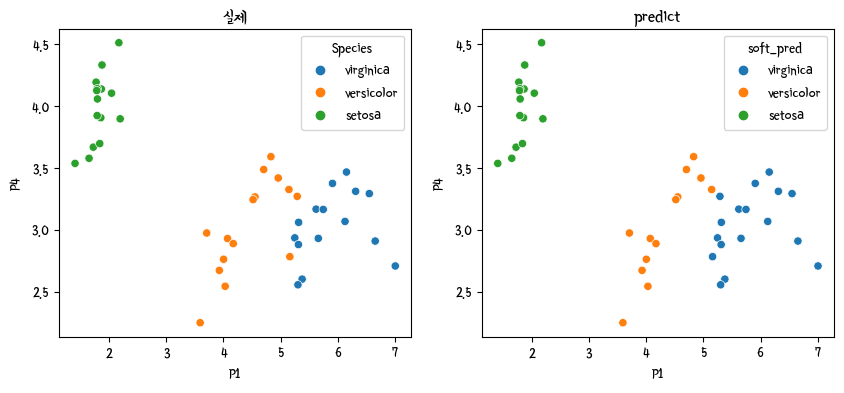

In [36]:
_,a=plt.subplots(1,2,figsize=(10,4))
sb.scatterplot(data=test,x="P1",y="P4",hue=target,ax=a[0])
sb.scatterplot(data=test,x="P1",y="P4",hue='soft_pred',ax=a[1])
a[0].set_title("실제")
a[1].set_title("predict")
plt.show()
plt.close()